In [1]:
import os
from FileFinder import find_files
import logging
import sys
from DataManager import DataManager
from tracab import TracabDataset, PlayerCountException
from DataPreprocessing import Dataset
from tqdm import tqdm 
import numpy as np

In [2]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
from kloppy import TRACABSerializer, to_pandas
from kloppy.domain.models.common import Point, Player, Team
from kloppy.domain.models.tracking import PlayerData, TrackingDataset, Frame

class Dataset:
    """ Data class which will be used to preprocess positional data """
    def __init__(self, sample_rate: float, home) -> None:
        self.dataset = None
        self.sample_rate = sample_rate
        self.switch_frames = None
        self.role_cluster = {}
        self.role_amount = 0

        # dataframes
        self.home_df = None # df from view of home team
        self.away_df = None # df from view of away team
        self.unique_player_df = None # df with all players
        self.role_player_df = None # df with cluster nr for each player currently on field
        self.phase_df = None

        # parse helpers
        self.ball_dist = None
        self.ball_owner_cutoff = 1
        self.parsed_result = {}
        self.parse_data = []
        self.pitch = None
        self.skip_counter = 0
        self.fps = 4   

        # helpers for data preprocessing
        self.player_encoder = {}
        self.player_decoder = {}
        self.matrix = []
        if home == "BEL":
            self.belgium_role = "home"
        else:
            self.belgium_role = "away"

    def open_dataset(self, datafilepath: str, metafilepath: str, alive: bool = False) -> TrackingDataset:
        """Parse file using kloppy lib and create unique player df

        Args:
            datafilepath (str): filepath
            metafilepath (str): filepath
            alive (bool, optional): Use only frames were ball is alive. Defaults to False.

        Returns:
            TrackingDataset: kloppy dataset
        """
        serializer = TRACABSerializer()
        with open(datafilepath, "rb") as data, open(metafilepath, "rb") as meta:
            dataset = serializer.deserialize(
                inputs={
                    "raw_data": data,
                    "metadata": meta,
                },
                options={
                    "sample_rate": self.sample_rate,
                    "only_alive": alive,
                    # "count_dead": True,
                }
            )
            # self.datasets["datafilepath"] = dataset
        self.dataset = dataset
        self.unique_player_df = to_pandas(dataset)
        self.unique_player_df = self.unique_player_df.loc[self.unique_player_df["ball_state"] == "alive"] 
        self.pitch = dataset.metadata.pitch_dimensions
        self.fps = int(self.sample_rate * dataset.metadata.frame_rate)
        belgium_x_coord = [playerdata.coordinates.x for player, playerdata in dataset.frames[0].players_data.items()  if player.player_id[0:4]==self.belgium_role]
        self.belgium_field_part = "left" if min(belgium_x_coord)<0.4 else "right"
        return dataset
    
    def substitution_detection(self) -> dict:
        """Find the frames per team where there was a substitution

        Returns:
            dict[str, list]: keys: home, away; values: list of frames of substitutions
        """
        dataset = self.dataset
        frames = {
            "home": {},
            "away": {}
        }
        old_players = list(map(lambda x: x.player_id, dataset.frames[0].players_coordinates.keys()))

        for index, frame in enumerate(dataset.frames):
            if frame.ball_state.value != "alive":
                continue
            current_players = list(map(lambda x: x.player_id, frame.players_coordinates.keys()))

            # detect player switches
            for team_id in ["home", "away"]:
                current_players_team = [p for p in current_players if team_id in p]
                old_players_team = [p for p in old_players if team_id in p]
                swapped_players = list(set(old_players_team) - set(current_players_team))
                swapping_players = list(set(current_players_team) - set(old_players_team))

                if len(swapped_players) > 0:

                    frames[team_id][index] = list(zip(swapped_players, swapping_players))
            old_players = current_players  


        # frames["away"].append(len(dataset.frames))
        # frames["home"].append(len(dataset.frames))
        self.switch_frames = frames
        return frames

    
    def generate_encodings(self):
        favourable_counter = 0
        opposing_counter = 11
        for frame in self.dataset.frames:
            for player in frame.players_data:
                if player.player_id not in self.player_encoder.keys():
                    if player.player_id[0:4] == self.belgium_role:
                        self.player_encoder[player.player_id] = favourable_counter
                        self.player_decoder[favourable_counter] = player.player_id
                        favourable_counter += 1
                    else:
                        self.player_encoder[player.player_id] = opposing_counter
                        self.player_decoder[opposing_counter] = player.player_id
                        opposing_counter += 1
            if len(self.player_encoder.keys()):
                break
        print(f"All players detected at the {frame.timestamp} timestamp")
    
    def _get_player_coordinates(self, frame):
        coord_matrix = np.zeros((22,2))
        ball_coord = np.array([frame.ball_coordinates.x, frame.ball_coordinates.y])
        ball_dist = np.zeros((22,1))
        player_speed = np.zeros((22,1))
        for player, playerdata in frame.players_data.items():
            if (self.belgium_field_part == "left") & (frame.period.id == 1):
                player_coord = [playerdata.coordinates.x, playerdata.coordinates.y]
                ball_coord = np.array([frame.ball_coordinates.x, frame.ball_coordinates.y])
                
            elif (self.belgium_field_part == "left") & (frame.period.id == 2):
                player_coord = [1-playerdata.coordinates.x, playerdata.coordinates.y]
                ball_coord = np.array([1-frame.ball_coordinates.x, frame.ball_coordinates.y])
                
            elif (self.belgium_field_part == "right") & (frame.period.id == 1):
                player_coord = [1-playerdata.coordinates.x, playerdata.coordinates.y]
                ball_coord = np.array([1-frame.ball_coordinates.x, frame.ball_coordinates.y])
                
            else:
                player_coord = [playerdata.coordinates.x, playerdata.coordinates.y]
                ball_coord = np.array([frame.ball_coordinates.x, frame.ball_coordinates.y])
            
            coord_matrix[self.player_encoder[player.player_id]] = player_coord

            if ball_coord[0] > player_coord[0]:
                ball_dist[self.player_encoder[player.player_id]] = np.linalg.norm(player_coord - ball_coord)
            else:
                ball_dist[self.player_encoder[player.player_id]] = -np.linalg.norm(player_coord - ball_coord)

            player_speed[self.player_encoder[player.player_id]] = playerdata.speed
        return np.hstack((coord_matrix,ball_dist,player_speed))
    
    def _generate_all_features(self):
        # find substitutions
        self.substitution_detection()
        for index, frame in enumerate(self.dataset.frames):
            if frame.ball_state.value != "alive":
                continue
            # check if players should be swapped
            if index in self.switch_frames["home"].keys():
                swap_list = self.switch_frames["home"][index]
                for swap in swap_list:
                    self.player_decoder[self.player_encoder[swap[0]]] = swap[1]
                    self.player_encoder[swap[1]] = self.player_encoder[swap[0]]
            if index in self.switch_frames["away"]:
                swap_list = self.switch_frames["away"][index]
                for swap in swap_list:
                    self.player_decoder[self.player_encoder[swap[0]]] = swap[1]
                    self.player_encoder[swap[1]] = self.player_encoder[swap[0]]
            # generates coordinates
            frame_features = self._get_player_coordinates(frame)
            self.matrix.append(frame_features)
        self.matrix = np.array(self.matrix)
        
        # get direction vector for x-coords
        self.matrix = np.transpose(self.matrix, axes=[0, 2, 1])
        x_coords = self.matrix[:,0,:]
        x_directions = np.diff(x_coords, axis=0)
        x_directions = np.expand_dims(np.vstack((np.zeros((1,self.matrix.shape[2])),x_directions)), axis=1)
        # get direction vector for y-coords
        y_coords = self.matrix[:,1,:]
        y_directions = np.diff(y_coords, axis=0)
        y_directions = np.expand_dims(np.vstack((np.zeros((1,self.matrix.shape[2])),y_directions)), axis=1)
        # get movement angle in radians
        movement_direction = np.arctan2(y_directions, x_directions)
        # get avg positions accumulated
        accumulated_xcoordinates = np.cumsum(x_coords, axis=0)
        nr_of_frames = np.arange(1,self.matrix.shape[0]+1,1)
        average_xcoordinates = (accumulated_xcoordinates.T / nr_of_frames).T
        avg_position_fav = np.argsort(average_xcoordinates[:,0:11], axis=1).argsort(axis=1)
        avg_position_opsing = np.argsort(average_xcoordinates[:,11:], axis=1).argsort(axis=1)
        avg_position_total = np.expand_dims(np.hstack((avg_position_fav,avg_position_opsing)), axis=1)
        # concatenate new variables
        self.matrix = np.concatenate((self.matrix, x_directions, y_directions, movement_direction, avg_position_total), axis=1)


In [4]:
logging.basicConfig(level=logging.WARN)
files = find_files("../football_games/EC2020")
for file in tqdm(files[0:1]):
    dataset = Dataset(1/5, file.home)
    dataset.open_dataset(file.datafile, file.metafile)

100%|██████████| 1/1 [00:06<00:00,  6.67s/it]


In [49]:
x = np.concatenate((np.zeros((dataset.matrix.shape[0],11)),np.ones((dataset.matrix.shape[0],11))), axis=1)

In [51]:
x.shape

(21121, 22)

In [5]:
dataset.generate_encodings()

All players detected at the 0.0 timestamp


In [41]:
len(dataset.dataset.frames[0].players_coordinates.keys())

22

In [217]:
dataset.player_encoder

{'home_3': 11,
 'home_18': 12,
 'home_4': 13,
 'home_8': 14,
 'home_1': 15,
 'away_4': 0,
 'home_20': 16,
 'away_9': 1,
 'home_2': 17,
 'away_10': 2,
 'home_22': 18,
 'home_14': 19,
 'away_1': 3,
 'home_10': 20,
 'away_22': 4,
 'away_24': 5,
 'home_6': 21,
 'away_3': 6,
 'away_18': 7,
 'away_25': 8,
 'away_6': 9,
 'away_7': 10}

In [218]:
dataset.switch_frames

In [6]:
dataset._generate_all_features()

In [8]:
dataset.matrix

array([[[ 3.22761905e-01,  5.03619048e-01,  4.96571429e-01, ...,
          5.88190476e-01,  5.02666667e-01,  5.70857143e-01],
        [ 4.72647059e-01,  4.95588235e-01,  8.52205882e-01, ...,
          5.07352941e-01,  6.37500000e-01,  3.77941176e-01],
        [ 1.82306346e-01, -0.00000000e+00,  3.56687279e-01, ...,
         -8.53858000e-02,  1.41914960e-01, -1.35505690e-01],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.00000000e+00,  1.00000000e+01,  8.00000000e+00, ...,
          4.00000000e+00,  1.00000000e+00,  2.00000000e+00]],

       [[ 3.24857143e-01,  5.02857143e-01,  4.97523810e-01, ...,
          5.87619048e-01,  5.01714286e-01,  5.71047619e-01],
        [ 4.71617647e-01,  4.96176471e-01,  8.53676471e-01, ...,
          5.08088235e-01,  6.37500000e

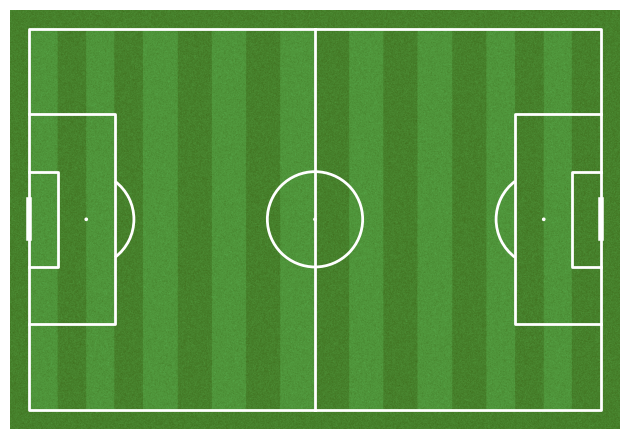

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from mplsoccer.pitch import Pitch
# Generate pitch
pitch = Pitch(pitch_color='grass', line_color='white', stripe=True)
fig, ax = pitch.draw()

In [23]:
scat = ax.scatter([], [], c="b", s=50)

def init():
    scat.set_offsets(np.array([]).reshape(0, 2))
    return (scat,)

def update(frame):
    scat.set_offsets(dataset.matrix[frame,[0,1],:])
    return (scat,)

In [24]:
ani = animation.FuncAnimation(fig=fig, func=update, frames=dataset.matrix.shape[0], init_func=init, interval=100)
plt.show()

In [25]:
ani.save('player_movement_5_frames.mp4', writer='ffmpeg')

ValueError: 'vertices' must be 2D with shape (N, 2), but your input has shape (1, 44)

In [22]:
dataset.matrix[0,[0,1],:].shape

(2, 22)

In [211]:
# get direction vector for x-coords
# matrix = np.transpose(matrix, axes=[0, 2, 1])
x_coords = matrix[:,0,:]
x_directions = np.diff(x_coords, axis=0)
x_directions = np.expand_dims(np.vstack((np.zeros((1,matrix.shape[2])),x_directions)), axis=1)
# get direction vector for y-coords
y_coords = matrix[:,1,:]
y_directions = np.diff(y_coords, axis=0)
y_directions = np.expand_dims(np.vstack((np.zeros((1,matrix.shape[2])),y_directions)), axis=1)
# get movement angle in radians
movement_direction = np.arctan2(y_directions, x_directions)
# get avg positions accumulated
accumulated_xcoordinates = np.cumsum(x_coords, axis=0)
nr_of_frames = np.arange(1,matrix.shape[0]+1,1)
average_xcoordinates = (accumulated_xcoordinates.T / nr_of_frames).T
avg_position_fav = np.argsort(average_xcoordinates[:,0:11], axis=1).argsort(axis=1)
avg_position_opsing = np.argsort(average_xcoordinates[:,11:], axis=1).argsort(axis=1)
avg_position_total = np.expand_dims(np.hstack((avg_position_fav,avg_position_opsing)), axis=1)
# concatenate new variables
matrix = np.concatenate((matrix, x_directions, y_directions, movement_direction, avg_position_total), axis=1)


In [212]:
matrix.shape

(21121, 8, 22)

In [ ]:
import numpy as np

# Example 3D matrix
matrix_3d = np.random.rand(2, 3, 4)  # Replace this with your 3D matrix

print("Original 3D matrix:")
print(matrix_3d)

# Swap the second and third dimensions using transpose
swapped_matrix = np.transpose(matrix_3d, axes=[0, 2, 1])

print("\nMatrix with swapped 2nd and 3rd dimensions:")
print(swapped_matrix)


In [191]:
x_directions.shape

(21120, 22)

In [96]:
17920 in dataset.switch_frames["home"].keys()

True

In [33]:
frames

{'home': {17920: [('home_14', 'home_11')],
  21341: [('home_20', 'home_19'), ('home_18', 'home_17')],
  27787: [('home_8', 'home_9'), ('home_10', 'home_26')]},
 'away': {22971: [('away_25', 'away_23'), ('away_24', 'away_15')],
  25599: [('away_9', 'away_20')],
  27787: [('away_7', 'away_17')]}}

In [28]:
x = dataset.player_decoder
x

{}

In [26]:
for frame in 

{17920: [('home_14', 'home_11')],
 21341: [('home_20', 'home_19'), ('home_18', 'home_17')],
 27787: [('home_8', 'home_9'), ('home_10', 'home_26')]}

In [22]:
x
f = 17920

for swap in x[frames["home"][f]]:
    x[swap[1]] = x[swap[0]]
x

TypeError: unhashable type: 'list'

In [18]:
frames["home"]

{17920: [('home_14', 'home_11')],
 21341: [('home_20', 'home_19'), ('home_18', 'home_17')],
 27787: [('home_8', 'home_9'), ('home_10', 'home_26')]}

In [20]:
x = np.random.random(1)
y = np.random.random(3)
np.append(x,[y,y])

array([0.13022604, 0.60488494, 0.07212837, 0.90913445, 0.60488494,
       0.07212837, 0.90913445])

In [2]:
logging.basicConfig(level=logging.WARN)
files = find_files("../football_games/EC2020")
# files += find_files("../football_games/WC2022-Qualifiers")
# files += find_files("../football_games/WC2022")

dm = DataManager(files)

In [9]:
frames

{'home': [0, 17920, 21341, 27787, 28461],
 'away': [0, 22971, 25599, 27787, 28461]}

In [14]:
dm.read_memsafe()

Total file count:   0%|          | 0/7 [00:00<?, ?it/s]

/Users/karol/.pyenv/versions/3.9.17/envs/DissEnv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/karol/.pyenv/versions/3.9.17/envs/DissEnv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/karol/.pyenv/versions/3.9.17/envs/DissEnv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/karol/.pyenv/versions/3.9.17/envs/DissEnv/lib/python3.9/site-packa

In [17]:
dm.read_datasets()

Total file count: 100%|██████████| 7/7 [00:46<00:00,  6.66s/it]


In [67]:
dm.matches[["ball_actual_x","ball_owner"]]

,ball_actual_x,ball_owner
0,0.496381,True
1,0.497143,True
2,0.497810,True
3,0.519333,True
4,0.535143,True
...,...,...
137177,0.541905,True
137178,0.551619,True
137179,0.561429,True
137180,0.571143,True


In [64]:
dm.datasets[0].role_amount

0

In [154]:
frame = dm.datasets[0].dataset.frames[0]
frame

Frame(period=Period(id=1, start_timestamp=75602.96, end_timestamp=78377.96, attacking_direction=home-away), timestamp=0.0, ball_owning_team=Team(team_id='away', name='away', ground=away, players=[Player(player_id='away_4', team=..., jersey_no=4, name=None, first_name=None, last_name=None, starting=None, position=None, attributes={}), Player(player_id='away_9', team=..., jersey_no=9, name=None, first_name=None, last_name=None, starting=None, position=None, attributes={}), Player(player_id='away_10', team=..., jersey_no=10, name=None, first_name=None, last_name=None, starting=None, position=None, attributes={}), Player(player_id='away_1', team=..., jersey_no=1, name=None, first_name=None, last_name=None, starting=None, position=None, attributes={}), Player(player_id='away_22', team=..., jersey_no=22, name=None, first_name=None, last_name=None, starting=None, position=None, attributes={}), Player(player_id='away_24', team=..., jersey_no=24, name=None, first_name=None, last_name=None, star

In [91]:
unique_player_df = dm.datasets[0].unique_player_df
unique_player_df = unique_player_df.reindex(sorted(unique_player_df.columns), axis=1)
unique_player_df["left"] = unique_player_df["period_id"].apply(lambda x: dm.datasets[0].dataset.metadata.periods[x-1].attacking_direction.value.split('-')[0])
extra_cols = ["left"]

role_player_df = unique_player_df.loc[:, ["left"]]

In [120]:
old_players = list(map(lambda x: x.player_id, dm.datasets[0].dataset.frames[0].players_coordinates.keys()))

In [152]:
dm.datasets[0].dataset.frames[28450].period.id

2

In [39]:
dataset.dataset.frames[0].timestamp

0.0

In [241]:
frame = dm.datasets[1].dataset.frames[0]

belgium_x_coord = [playerdata.coordinates.x for player, playerdata in frame.players_data.items() if player.player_id[0:4]=="home"]
belgium_field_part = "left" if min(belgium_x_coord)<0.4 else "right"
min(belgium_x_coord)


0.010476190476190476

In [252]:
import numpy as np
# Replace this with your actual 2D matrix representing player x-coordinates over timestamps
player_matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Calculate differences along the vertical dimension (timestamps)
differences = np.diff(player_matrix, axis=0)
differences
np.vstack((np.zeros((1,3)),differences))

array([[0., 0., 0.],
       [3., 3., 3.],
       [3., 3., 3.]])

In [271]:
matrix = np.array([[4, 9, 1],
                   [7, 3, 5],
                   [2, 8, 6]])

# Calculate rank values along the y-axis (rows)
rank_values = np.argsort(-matrix, axis=1).argsort(axis=1)

print("Rank values along the y-axis:")
print(rank_values)

Rank values along the y-axis:
[[1 0 2]
 [0 2 1]
 [2 0 1]]


In [295]:
array_2d.expand_dims(axis=1)

AttributeError: 'numpy.ndarray' object has no attribute 'expand_dims'

In [294]:
# Example 3D array (3x3x3)
array_3d = np.random.rand(2, 2, 2)

# Example 2D array to be added (3x3)
array_2d = np.ones((2, 2))

# Add a new axis to the 2D array to make it 3D (3x3x1)
reshaped_2d_array = np.expand_dims(array_2d, axis=1)
reshaped_2d_array.shape
# Concatenate the two arrays along the second dimension
stacked_array = np.concatenate((array_3d, reshaped_2d_array), axis=1)
stacked_array[:,2,:]

array([[1., 1.],
       [1., 1.]])

In [259]:
accumulated_coordinates = np.array([[1, 3, 6], [4, 9, 15], [7, 15, 24]]) 
z = (accumulated_coordinates.T / np.arange(1,4,1)).T

In [260]:
z.rank

array([[1.        , 3.        , 6.        ],
       [2.        , 4.5       , 7.5       ],
       [2.33333333, 5.        , 8.        ]])

In [243]:
for player, playerdata in frame.players_data.items():
    pass

In [79]:
for p in frame.players_coordinates:
    

home_3
home_18
home_4
home_8
home_1
away_4
home_20
away_9
home_2
away_10
home_22
home_14
away_1
home_10
away_22
away_24
home_6
away_3
away_18
away_25
away_6
away_7


In [85]:
frame.players_data.items()

dict_items([(Player(player_id='home_3', team=Team(team_id='home', name='home', ground=home, players=[..., Player(player_id='home_18', team=..., jersey_no=18, name=None, first_name=None, last_name=None, starting=None, position=None, attributes={}), Player(player_id='home_4', team=..., jersey_no=4, name=None, first_name=None, last_name=None, starting=None, position=None, attributes={}), Player(player_id='home_8', team=..., jersey_no=8, name=None, first_name=None, last_name=None, starting=None, position=None, attributes={}), Player(player_id='home_1', team=..., jersey_no=1, name=None, first_name=None, last_name=None, starting=None, position=None, attributes={}), Player(player_id='home_20', team=..., jersey_no=20, name=None, first_name=None, last_name=None, starting=None, position=None, attributes={}), Player(player_id='home_2', team=..., jersey_no=2, name=None, first_name=None, last_name=None, starting=None, position=None, attributes={}), Player(player_id='home_22', team=..., jersey_no=22

In [162]:
dm.datasets[0].unique_player_df

,period_id,timestamp,ball_state,ball_owning_team_id,ball_x,ball_y,home_3_x,home_3_y,home_3_d,home_3_s,...,away_17_d,away_17_s,home_26_x,home_26_y,home_26_d,home_26_s,home_9_x,home_9_y,home_9_d,home_9_s
2,1,0.40,alive,away,0.496381,0.495588,0.316476,0.390000,None,0.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.60,alive,away,0.497143,0.496176,0.316095,0.390441,None,0.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.80,alive,away,0.497810,0.496765,0.316095,0.390441,None,0.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,1.00,alive,away,0.519333,0.501618,0.316381,0.390147,None,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,1.20,alive,away,0.535143,0.502647,0.317333,0.389559,None,0.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28451,2,2915.16,alive,away,0.002476,0.950441,0.402952,0.689853,None,0.89,...,NaN,0.87,0.007143,0.982647,NaN,1.02,0.084476,0.679853,NaN,1.28
28452,2,2915.36,alive,away,-0.003238,0.938971,0.404286,0.690147,None,0.83,...,NaN,0.89,0.006286,0.982647,NaN,0.81,0.084095,0.683676,NaN,1.29
28453,2,2915.56,alive,away,-0.008762,0.927353,0.405524,0.690147,None,0.75,...,NaN,0.91,0.004952,0.981471,NaN,0.64,0.083238,0.687353,NaN,1.33
28454,2,2915.76,alive,away,-0.014571,0.919118,0.406762,0.689706,None,0.64,...,NaN,0.69,0.003714,0.979265,NaN,0.72,0.081619,0.692059,NaN,1.41


In [23]:
for col in dm.matches.columns:
    print(col)

index
info_was_dead
frame_id
info_period
timestamp
info_time
ball_actual_x
ball_actual_y
ball_actual_z
ball_px
ball_py
ball_psymy
ball_dir_x
ball_dir_y
ball_unnorm_speed
ball_owner
unnorm_pressure
friend_unnorm_pressure
enemy_unnorm_pressure
actual_dir_x
actual_dir_y
friend_actual_dir_x
friend_actual_dir_y
enemy_actual_dir_x
enemy_actual_dir_y
friend_centroid_actual_x
friend_centroid_actual_y
friend_centroid_px
friend_centroid_py
friend_centroid_psymy
friend_centroid_unnorm_speed
friend_nokeepercentroid_actual_x
friend_nokeepercentroid_actual_y
friend_nokeepercentroid_px
friend_nokeepercentroid_py
friend_nokeepercentroid_psymy
friend_nokeepercentroid_unnorm_speed
enemy_centroid_actual_x
enemy_centroid_actual_y
enemy_centroid_px
enemy_centroid_py
enemy_centroid_psymy
enemy_centroid_unnorm_speed
enemy_nokeepercentroid_actual_x
enemy_nokeepercentroid_actual_y
enemy_nokeepercentroid_px
enemy_nokeepercentroid_py
enemy_nokeepercentroid_psymy
enemy_nokeepercentroid_unnorm_speed
friend_0_rolec

In [1]:
features = ["x", "y"]
feature_group = {
        key: ["first", "last", "min", "max", "mean", "std"] for key in features
    }

In [2]:
logging.basicConfig(level=logging.WARN)
files = find_files("../football_games/EC2020")

In [3]:
t = TracabDataset(1 / 5)
f = files[0]
# t.open_dataset(f.datafile, f.metafile, alive)

In [165]:
frame.ball_owning_team.ground

away

In [5]:
t.open_dataset(f.datafile, f.metafile, False)

In [ ]:
f.datafile